In [4]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn import metrics

In [5]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Email network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [6]:
N_EPOCH=5
ATTRS = False

In [7]:
import sys
sys.path.append("..")

from lib.generators.AttributedNetwork import AttributedNetwork


generator = AttributedNetwork(
    '../data/',
    'citeseer',
    features_to_normalize=['RAI', 'JC', 'AAI', 'PA'],
    with_attributes=ATTRS,
    seed=seed,
    vebrose=True
)

feature_names = generator.t_feature_names

INFO: Verbose output.
INFO: Reading data ...
INFO: Success!
INFO: Train/test splitting the data...
INFO: Success!
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features


In [8]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

link_prediction_train.dropna(inplace=True)
link_prediction_test.dropna(inplace=True)
classifier_test.dropna(inplace=True)

In [9]:
link_prediction_train.head()

,node1,node2,goal,RAI,JC,AAI,PA
0,531,2015,0.0,0.0,0.0,0.0,0.000000
1,1357,2890,0.0,0.0,0.0,0.0,0.000265
2,2822,3247,0.0,0.0,0.0,0.0,0.000000
3,260,2619,0.0,0.0,0.0,0.0,0.001325
4,2629,3386,0.0,0.0,0.0,0.0,0.000000


## Step 2
### Link prediction model

In [10]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


from keras import Input
from keras import layers as l
from keras.models import Model

from tensorflow.keras.utils import plot_model


def model(feature_names, attr_dim, attrs=True, embed_dim=4, hidden_dim=64):
    """
    A simple DL model for classification
    """

    # inputs to topological features
    feature_input = Input(shape=(len(feature_names), ), name='Topological features input')

    # node_attributes inputs
    attr_input_1 = Input(shape=(attr_dim, ), name='Node 1 attributes') if attr_dim > 0 else None
    attr_input_2 = Input(shape=(attr_dim, ), name='Node 2 attributes') if attr_dim > 0 else None

    # dynamic representation the attributes
    c = l.Concatenate()([attr_input_1, attr_input_2])
    attrs_dyn = l.Dense(embed_dim, activation='relu', name='Dynamic representation of the the attributes')(c)

    concat = l.Concatenate()([feature_input, attrs_dyn])

    if attrs:
        hidden = l.Dense(hidden_dim, activation='relu', name='Hidden layer 1')(concat)
    else:
        hidden = l.Dense(hidden_dim, activation='relu', name='Hidden layer 1')(feature_input)
        
    hidden = l.Dense(hidden_dim, activation='relu', name='Hidden layer 2')(hidden)

    out = l.Dense(1, activation='sigmoid', name='output')(hidden)

    if attrs:
        model = Model([feature_input, attr_input_1, attr_input_2], out)
    else:
        model = Model(feature_input, out)

    model.compile(optimizer='adam', loss='poisson', metrics=['accuracy'])

    return model

Using plaidml.keras.backend backend.
DEBUG: Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


In [17]:
# function to rearange data for training

def data_arrange(df, feature_names, train=True, attrs=True, goal='goal'):
    x_features = df[feature_names].values

    x_attrs_1 = np.array([np.array(item) for item in df['node_1_attrs'].values]) if attrs else []
    x_attrs_2 = np.array([np.array(item) for item in df['node_2_attrs'].values]) if attrs else []

    y = df[goal].values if train else None

    if attrs:
        return [x_features, x_attrs_1, x_attrs_2], y
    else:
        return x_features, y

In [18]:
attr_dim = len(link_prediction_train.head(1)['node_1_attrs'].values[0]) if ATTRS else 1

link_prediction_model = model(feature_names, attr_dim, attrs=ATTRS)
link_prediction_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Topological features input ( (None, 4)                 0         
_________________________________________________________________
Hidden layer 1 (Dense)       (None, 64)                320       
_________________________________________________________________
Hidden layer 2 (Dense)       (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


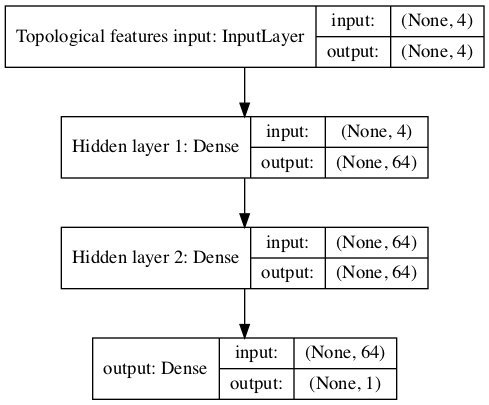

In [19]:
plot_model(link_prediction_model, show_shapes=True)

In [20]:
x, y = data_arrange(link_prediction_train, feature_names, attrs=ATTRS)
link_prediction_model.fit(x, y, epochs=N_EPOCH) 

Epoch 1/5
7578/7578 [==============================] - 5s 649us/step - loss: 0.8141 - acc: 0.6774
Epoch 2/5
7578/7578 [==============================] - 2s 277us/step - loss: 0.7911 - acc: 0.7061
Epoch 3/5
7578/7578 [==============================] - 2s 326us/step - loss: 0.7808 - acc: 0.7304
Epoch 4/5
7578/7578 [==============================] - 3s 393us/step - loss: 0.7741 - acc: 0.7453
Epoch 5/5
7578/7578 [==============================] - 3s 389us/step - loss: 0.7714 - acc: 0.7524


In [21]:
# predicting the links

x, _ = data_arrange(link_prediction_test, feature_names, train=False, attrs=ATTRS)

prob = link_prediction_model.predict(x).squeeze()
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_test.join(prob)
link_proba.head(5)

In [ ]:
from sklearn.metrics import roc_curve, auc


def plot_auc(df, x='goal', y='prob'):
    fig, ax = plt.subplots(1)

    fpr, tpr, _ = roc_curve(df[x], df[y])
    sn.lineplot(x=fpr, y=tpr, ax=ax)

    ax.legend([f'ROC curve, AUC = {auc(fpr, tpr):.4f}'])
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')


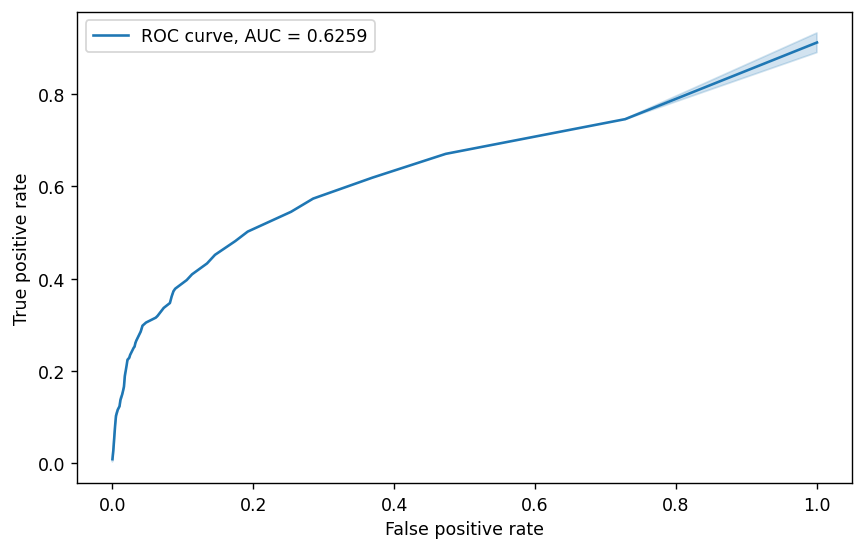

In [ ]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125


# ROC-AUC for the link prediction model
plot_auc(link_proba, x='goal', y='prob')

## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [ ]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,prob,abs_error
0,83,3770,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.001589,0.285669,0.285669
1,2259,2895,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.015012,0.106667,0.031032,0.021446,0.273677,0.726323
2,3417,3418,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000794,0.285281,0.714719
3,23,3310,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.004766,0.287228,0.287228
4,3695,4060,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.015091,0.292328,0.707672


In [ ]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.6122303009033203

In [ ]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,prob,abs_error,quality_label
0,83,3770,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.001589,0.285669,0.285669,1
1,2259,2895,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.015012,0.106667,0.031032,0.021446,0.273677,0.726323,0
2,3417,3418,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000794,0.285281,0.714719,0
3,23,3310,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.004766,0.287228,0.287228,1
4,3695,4060,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.015091,0.292328,0.707672,0


In [ ]:
classification_model = model(feature_names, attr_dim, attrs=ATTRS)
classification_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Topological features input ( (None, 4)                 0         
_________________________________________________________________
Hidden layer 1 (Dense)       (None, 64)                320       
_________________________________________________________________
Hidden layer 2 (Dense)       (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


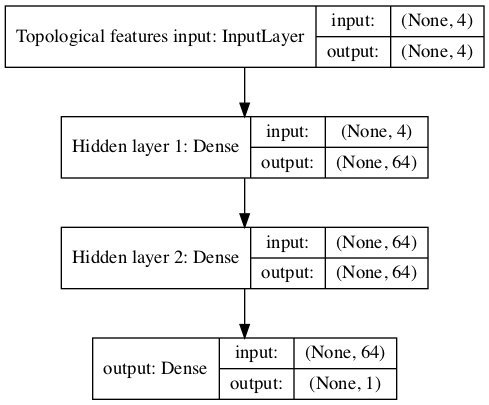

In [ ]:
plot_model(classification_model, show_shapes=True)

In [ ]:
x, y = data_arrange(link_proba, feature_names, goal='quality_label', attrs=ATTRS)

classification_model.fit(x, y, epochs=N_EPOCH) 

Epoch 1/5
1601/1601 [==============================] - 1s 322us/step - loss: 0.8362 - acc: 0.6596
Epoch 2/5
1601/1601 [==============================] - 0s 292us/step - loss: 0.8045 - acc: 0.6927
Epoch 3/5
1601/1601 [==============================] - 0s 268us/step - loss: 0.7742 - acc: 0.6902
Epoch 4/5
1601/1601 [==============================] - 0s 155us/step - loss: 0.7627 - acc: 0.6939
Epoch 5/5
1601/1601 [==============================] - 0s 222us/step - loss: 0.7596 - acc: 0.6958


In [ ]:
# testing the classifier

T = 0.5

x, _ = data_arrange(classifier_test, feature_names, train=False, attrs=ATTRS)

quality_probability = classification_model.predict(x).squeeze()
link_probability = link_prediction_model.predict(x).squeeze()

quality_label = [1 if i > T else 0 for i in quality_probability]

classifier_test = classifier_test.join(pd.Series(quality_probability, name='predicted_quality_prob'))
classifier_test = classifier_test.join(pd.Series(link_probability, name='predicted_link_probability'))
classifier_test = classifier_test.join(pd.Series(quality_label, name='predicted_quality_label'))

In [ ]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['predicted_link_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.6744440793991089

In [ ]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,predicted_quality_prob,predicted_link_probability,predicted_quality_label,true_abs_error,true_quality_label
0,2298,3334,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.346...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000795,0.538204,0.285281,1,0.285281,1
1,994,2647,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000265,0.540366,0.285022,1,0.285022,1
2,274,3049,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001325,0.536041,0.285541,1,0.285541,1
3,520,3899,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000265,0.540366,0.285022,1,0.285022,1
4,351,1688,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001060,0.537122,0.285411,1,0.285411,1


In [ ]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
0                     801
1                     801
dtype: int64

In [ ]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          1219
0                           383
dtype: int64

In [ ]:
from sklearn import metrics

classifier_test.dropna(inplace=True)
y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    metrics.precision_score(y_true, y_pred),
    metrics.recall_score(y_true, y_pred),
    metrics.f1_score(y_true, y_pred)
])

scores_df

,Metric,Score
0,Sample length,1602.000000
1,Precision,0.634947
2,Recall,0.966292
3,F1 score,0.766337


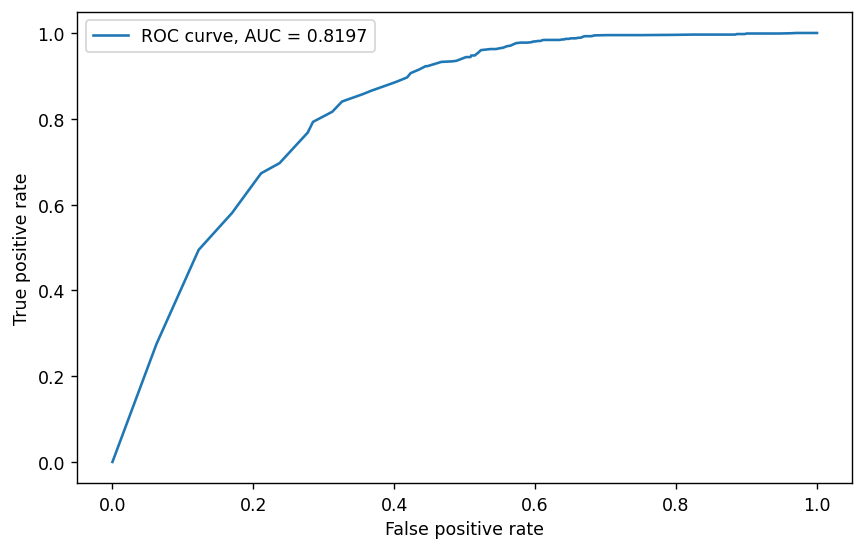

In [ ]:
plot_auc(classifier_test, 'true_quality_label', 'predicted_quality_prob')